## Import & Dataset

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications import InceptionV3
from keras.models import load_model
import keras_tuner as kt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.models import Sequential
import splitfolders

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import optuna
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from torch.utils.data import WeightedRandomSampler


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
source = f'D:\SEMESTER 7\TA\dataset\MangoLeafBD'
destination = f'D:\SEMESTER 7\TA\dataset\MangoLeaf'
splitfolders.ratio(source, destination, seed = 42, ratio = (0.64, 0.16, 0.2))

Copying files: 4000 files [00:52, 75.79 files/s] 


In [ ]:
train_dataset = image_dataset_from_directory(f'D:\\SEMESTER 7\\TA\\dataset\\MangoLeaf\\train',
 batch_size = 32, image_size = (224,224), color_mode = 'rgb', seed = 42, shuffle = True)
val_dataset =image_dataset_from_directory(f'D:\\SEMESTER 7\\TA\\dataset\\MangoLeaf\\val',
 batch_size = 32, image_size = (224,224), color_mode = 'rgb', seed = 42, shuffle = False)
test_dataset = image_dataset_from_directory(f'D:\\SEMESTER 7\\TA\\dataset\\MangoLeaf\\test',
 batch_size = 32, image_size = (224,224), color_mode = 'rgb', seed = 42, shuffle = False)

Found 2560 files belonging to 8 classes.
Found 640 files belonging to 8 classes.
Found 800 files belonging to 8 classes.


## ResNet50

In [ ]:
def build_model(hp):
    resnet50 = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
    resnet50.trainable = False
    class_num = 8

    model = tf.keras.models.Sequential()
    model.add(resnet50)
    model.add(Flatten())

    for i in range(0, hp.Int('num_layers', 0, 3)):
        units = hp.Int(f'dense_{i}_units', min_value = 32, max_value = 1024, step = 32)
        dropout_rate = hp.Float(f'dropout_{i}_rate', min_value = 0.3, max_value = 0.7, step = 0.1)

        model.add(Dense(units = units, activation = 'relu'))
        model.add(Dropout(rate = dropout_rate))

    model.add(Dense(class_num, activation = 'softmax'))

    optimizer = Adam(learning_rate = hp.Choice('learning_rate', values = [0.1, 0.01, 0.001]))
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(
    build_model,  # Fungsi untuk membangun model
    objective='val_accuracy',  # Metrik yang akan dioptimalkan
    max_epochs=10,  # Jumlah maksimum epoch
    factor=3,  # Faktor reduksi untuk jumlah konfigurasi
    directory='D:\\SEMESTER 7\\TA\\tuning',  # Direktori untuk menyimpan hasil pencarian hiperparameter
    project_name='resnet50new'  # Nama proyek pencarian hiperparameter
)

Reloading Tuner from D:\SEMESTER 7\TA\tuning\resnet50new\tuner0.json


In [ ]:
# Menentukan Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik yang akan dipantau (dalam contoh, kita pantau loss pada data validasi)
    patience=3,  # Jumlah epoch tanpa perbaikan sebelum pelatihan dihentikan
    restore_best_weights=True  # Mengembalikan bobot terbaik jika pelatihan dihentikan
)

In [ ]:
tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_learning_rate = best_hps.get('learning_rate')
optimizer = Adam(learning_rate=best_learning_rate)
tuner.results_summary()

Results summary
Results in D:\SEMESTER 7\TA\tuning\resnet50new
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0029 summary
Hyperparameters:
num_layers: 1
learning_rate: 0.001
dense_0_units: 864
dropout_0_rate: 0.6000000000000001
dense_1_units: 448
dropout_1_rate: 0.3
dense_2_units: 128
dropout_2_rate: 0.5
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.989062488079071

Trial 0016 summary
Hyperparameters:
num_layers: 0
learning_rate: 0.1
dense_0_units: 448
dropout_0_rate: 0.6000000000000001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
dense_1_units: 608
dropout_1_rate: 0.3
dense_2_units: 736
dropout_2_rate: 0.3
Score: 0.987500011920929

Trial 0017 summary
Hyperparameters:
num_layers: 0
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
dense_0_units: 1024
dropout_0_rate: 0.5
dense_1_units: 832
dropout_1_rate: 0.6000

In [ ]:
tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_learning_rate = best_hps.get('learning_rate')
optimizer = Adam(learning_rate=best_learning_rate)
tuner.results_summary()

Trial 30 Complete [00h 18m 22s]
val_accuracy: 0.989062488079071

Best val_accuracy So Far: 0.989062488079071
Total elapsed time: 03h 05m 26s
Results summary
Results in D:\SEMESTER 7\TA\tuning\resnet50new
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0029 summary
Hyperparameters:
num_layers: 1
learning_rate: 0.001
dense_0_units: 864
dropout_0_rate: 0.6000000000000001
dense_1_units: 448
dropout_1_rate: 0.3
dense_2_units: 128
dropout_2_rate: 0.5
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.989062488079071

Trial 0016 summary
Hyperparameters:
num_layers: 0
learning_rate: 0.1
dense_0_units: 448
dropout_0_rate: 0.6000000000000001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
dense_1_units: 608
dropout_1_rate: 0.3
dense_2_units: 736
dropout_2_rate: 0.3
Score: 0.987500011920929

Trial 0017 summary
Hyperparameters:
num_layers: 0
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_ep

In [ ]:
model = load_model('D:\\SEMESTER 7\\TA\\modelbaru\\resnet50new.h5')
val_loss, val_acc = model.evaluate(val_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

25/25 [==============================] - 21s 827ms/step - loss: 0.5426 - accuracy: 0.9850


In [ ]:
model = load_model('D:\\SEMESTER 7\\TA\\modelbaru\\vgg16.h5')
val_loss, val_acc = model.evaluate(val_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

25/25 [==============================] - 43s 2s/step - loss: 1.2326 - accuracy: 0.9787


In [ ]:
model = load_model('D:\\SEMESTER 7\\TA\\modelbaru\\mobilenet.h5')
val_loss, val_acc = model.evaluate(val_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

25/25 [==============================] - 7s 262ms/step - loss: 0.1921 - accuracy: 0.9463


In [ ]:
model = load_model('D:\\SEMESTER 7\\TA\\modelbaru\\googlenet.h5')
val_loss, val_acc = model.evaluate(val_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

25/25 [==============================] - 11s 435ms/step - loss: 7536.2456 - accuracy: 0.7138


In [ ]:
model = build_model(best_hps)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)
model.summary()

Epoch 1/10
80/80 [==============================] - 201s 3s/step - loss: 10.1035 - accuracy: 0.8191 - val_loss: 0.5608 - val_accuracy: 0.9703
Epoch 2/10
80/80 [==============================] - 325s 4s/step - loss: 1.2868 - accuracy: 0.9563 - val_loss: 0.5970 - val_accuracy: 0.9734
Epoch 3/10
80/80 [==============================] - 325s 4s/step - loss: 0.6766 - accuracy: 0.9707 - val_loss: 0.7852 - val_accuracy: 0.9656
Epoch 4/10
80/80 [==============================] - 326s 4s/step - loss: 1.2250 - accuracy: 0.9594 - val_loss: 0.3929 - val_accuracy: 0.9828
Epoch 5/10
80/80 [==============================] - 326s 4s/step - loss: 1.0214 - accuracy: 0.9684 - val_loss: 0.4372 - val_accuracy: 0.9844
Epoch 6/10
80/80 [==============================] - 326s 4s/step - loss: 0.8222 - accuracy: 0.9754 - val_loss: 0.4836 - val_accuracy: 0.9828
Epoch 7/10
80/80 [==============================] - 326s 4s/step - loss: 0.6495 - accuracy: 0.9773 - val_loss: 0.2369 - val_accuracy: 0.9891
Epoch 8/10
8

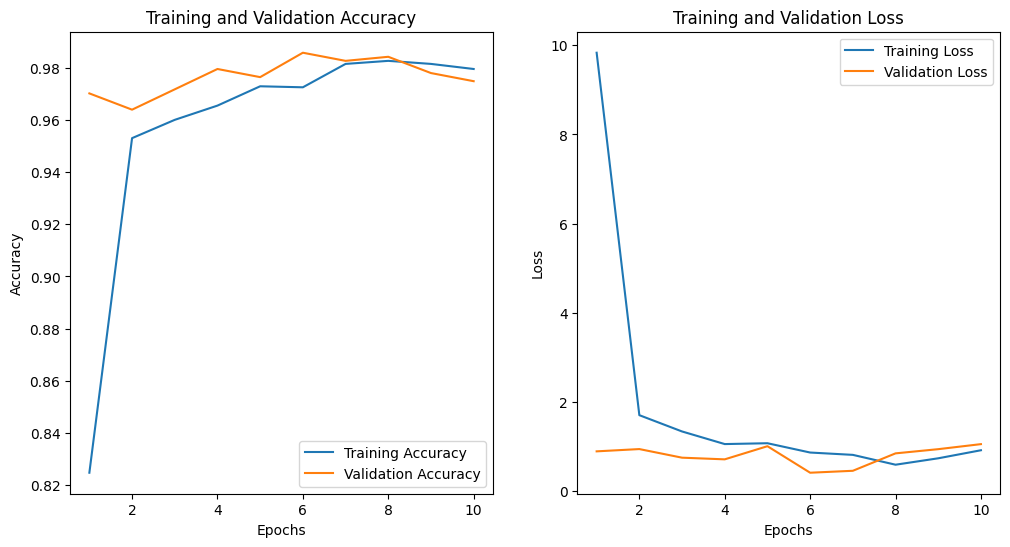

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plot Akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.save(f'D:\\SEMESTER 7\\TA\\modelbaru\\resnet50new.h5')

In [ ]:
accuracy = model.evaluate(test_dataset)[1] * 100
print("Accuracy:", accuracy)

25/25 [==============================] - 21s 839ms/step - loss: 1.2174 - accuracy: 0.4913
Accuracy: 49.12500083446503


In [ ]:
accuracy = model.evaluate(test_dataset)[1] * 100
print("Accuracy:", accuracy)

25/25 [==============================] - 21s 837ms/step - loss: 0.5426 - accuracy: 0.9850
Accuracy: 98.50000143051147


## VGG16

In [ ]:
def build_model(hp):
    vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
    vgg16.trainable = False
    class_num = 8

    model = tf.keras.models.Sequential()
    model.add(vgg16)
    model.add(Flatten())

    for i in range(0, hp.Int('num_layers', 0, 3)):
        units = hp.Int(f'dense_{i}_units', min_value = 32, max_value = 1024, step = 32)
        dropout_rate = hp.Float(f'dropout_{i}_rate', min_value = 0.3, max_value = 0.7, step = 0.1)

        model.add(Dense(units = units, activation = 'relu'))
        model.add(Dropout(rate = dropout_rate))

    model.add(Dense(class_num, activation = 'softmax'))

    optimizer = Adam(learning_rate = hp.Choice('learning_rate', values = [0.1, 0.01, 0.001]))
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(
    build_model,  # Fungsi untuk membangun model
    objective='val_accuracy',  # Metrik yang akan dioptimalkan
    max_epochs=10,  # Jumlah maksimum epoch
    factor=3,  # Faktor reduksi untuk jumlah konfigurasi
    directory='D:\\SEMESTER 7\\TA\\tuning',  # Direktori untuk menyimpan hasil pencarian hiperparameter
    project_name='vgg16'  # Nama proyek pencarian hiperparameter
)

In [ ]:
# Menentukan Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik yang akan dipantau (dalam contoh, kita pantau loss pada data validasi)
    patience=3,  # Jumlah epoch tanpa perbaikan sebelum pelatihan dihentikan
    restore_best_weights=True  # Mengembalikan bobot terbaik jika pelatihan dihentikan
)

In [ ]:
tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_learning_rate = best_hps.get('learning_rate')
optimizer = Adam(learning_rate=best_learning_rate)
tuner.results_summary()

Trial 30 Complete [00h 24m 18s]
val_accuracy: 0.987500011920929

Best val_accuracy So Far: 0.987500011920929
Total elapsed time: 05h 12m 13s
Results summary
Results in D:\SEMESTER 7\TA\tuning\vgg16
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0029 summary
Hyperparameters:
num_layers: 1
learning_rate: 0.001
dense_0_units: 768
dropout_0_rate: 0.4
dense_1_units: 576
dropout_1_rate: 0.5
dense_2_units: 32
dropout_2_rate: 0.4
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.987500011920929

Trial 0017 summary
Hyperparameters:
num_layers: 0
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
dense_0_units: 704
dropout_0_rate: 0.6000000000000001
dense_1_units: 736
dropout_1_rate: 0.5
dense_2_units: 416
dropout_2_rate: 0.3
Score: 0.9828125238418579

Trial 0014 summary
Hyperparameters:
num_layers: 0
learning_rate: 0.01
dense_0_units: 800
dropout_0_rate: 0.3
dense_1_units:

In [ ]:
model = build_model(best_hps)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)
model.summary()

Epoch 1/10
80/80 [==============================] - 180s 2s/step - loss: 5.4388 - accuracy: 0.8590 - val_loss: 1.5400 - val_accuracy: 0.9578
Epoch 2/10
80/80 [==============================] - 180s 2s/step - loss: 0.9915 - accuracy: 0.9648 - val_loss: 0.9629 - val_accuracy: 0.9688
Epoch 3/10
80/80 [==============================] - 180s 2s/step - loss: 0.7616 - accuracy: 0.9758 - val_loss: 0.8530 - val_accuracy: 0.9641
Epoch 4/10
80/80 [==============================] - 180s 2s/step - loss: 0.5387 - accuracy: 0.9840 - val_loss: 0.4823 - val_accuracy: 0.9750
Epoch 5/10
80/80 [==============================] - 180s 2s/step - loss: 0.4108 - accuracy: 0.9848 - val_loss: 1.3992 - val_accuracy: 0.9656
Epoch 6/10
80/80 [==============================] - 180s 2s/step - loss: 0.4404 - accuracy: 0.9852 - val_loss: 0.7070 - val_accuracy: 0.9781
Epoch 7/10
80/80 [==============================] - 180s 2s/step - loss: 0.3350 - accuracy: 0.9891 - val_loss: 0.9763 - val_accuracy: 0.9750
Epoch 8/10
80

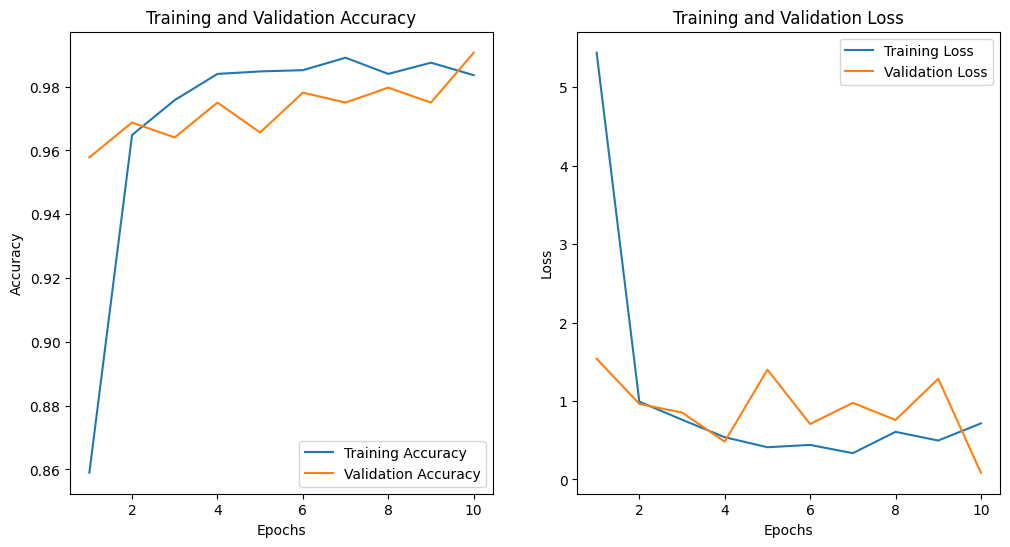

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plot Akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.save(f'D:\\SEMESTER 7\\TA\\modelbaru\\vgg16.h5')

In [ ]:
accuracy = model.evaluate(test_dataset)[1] * 100
print("Accuracy:", accuracy)

25/25 [==============================] - 43s 2s/step - loss: 1.2326 - accuracy: 0.9787
Accuracy: 97.87499904632568


## MobileNet

In [ ]:
def build_model(hp):
    mobilenet = MobileNet(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
    mobilenet.trainable = False
    class_num = 8

    model = tf.keras.models.Sequential()
    model.add(mobilenet)
    model.add(Flatten())

    for i in range(0, hp.Int('num_layers', 0, 3)):
        units = hp.Int(f'dense_{i}_units', min_value = 32, max_value = 1024, step = 32)
        dropout_rate = hp.Float(f'dropout_{i}_rate', min_value = 0.3, max_value = 0.7, step = 0.1)

        model.add(Dense(units = units, activation = 'relu'))
        model.add(Dropout(rate = dropout_rate))

    model.add(Dense(class_num, activation = 'softmax'))

    optimizer = Adam(learning_rate = hp.Choice('learning_rate', values = [0.1, 0.01, 0.001]))
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(
    build_model,  # Fungsi untuk membangun model
    objective='val_accuracy',  # Metrik yang akan dioptimalkan
    max_epochs=10,  # Jumlah maksimum epoch
    factor=3,  # Faktor reduksi untuk jumlah konfigurasi
    directory='D:\\SEMESTER 7\\TA\\tuning',  # Direktori untuk menyimpan hasil pencarian hiperparameter
    project_name='mobilenet'  # Nama proyek pencarian hiperparameter
)

In [ ]:
# Menentukan Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik yang akan dipantau (dalam contoh, kita pantau loss pada data validasi)
    patience=3,  # Jumlah epoch tanpa perbaikan sebelum pelatihan dihentikan
    restore_best_weights=True  # Mengembalikan bobot terbaik jika pelatihan dihentikan
)

In [ ]:
tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_learning_rate = best_hps.get('learning_rate')
optimizer = Adam(learning_rate=best_learning_rate)
tuner.results_summary()

Trial 30 Complete [00h 07m 46s]
val_accuracy: 0.9312499761581421

Best val_accuracy So Far: 0.942187488079071
Total elapsed time: 01h 01m 43s
Results summary
Results in D:\SEMESTER 7\TA\tuning\mobilenet
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0024 summary
Hyperparameters:
num_layers: 1
learning_rate: 0.001
dense_0_units: 928
dropout_0_rate: 0.5
dense_1_units: 672
dropout_1_rate: 0.5
dense_2_units: 576
dropout_2_rate: 0.5
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 0.942187488079071

Trial 0014 summary
Hyperparameters:
num_layers: 0
learning_rate: 0.01
dense_0_units: 672
dropout_0_rate: 0.4
dense_1_units: 992
dropout_1_rate: 0.5
dense_2_units: 832
dropout_2_rate: 0.4
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0006
Score: 0.940625011920929

Trial 0029 summary
Hyperparameters:
num_layers: 1
learning_rate: 0.001
dense_0_units: 960
dropout_0_rate: 0.5
den

In [ ]:
model = build_model(best_hps)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)
model.summary()

Epoch 1/10
80/80 [==============================] - 44s 536ms/step - loss: 9.5782 - accuracy: 0.6555 - val_loss: 0.6960 - val_accuracy: 0.8562
Epoch 2/10
80/80 [==============================] - 42s 526ms/step - loss: 0.5384 - accuracy: 0.8711 - val_loss: 0.3919 - val_accuracy: 0.8734
Epoch 3/10
80/80 [==============================] - 42s 525ms/step - loss: 0.3216 - accuracy: 0.9113 - val_loss: 0.3280 - val_accuracy: 0.8969
Epoch 4/10
80/80 [==============================] - 42s 526ms/step - loss: 0.2958 - accuracy: 0.9125 - val_loss: 0.2571 - val_accuracy: 0.9109
Epoch 5/10
80/80 [==============================] - 42s 526ms/step - loss: 0.2714 - accuracy: 0.9254 - val_loss: 0.2767 - val_accuracy: 0.9203
Epoch 6/10
80/80 [==============================] - 43s 533ms/step - loss: 0.2430 - accuracy: 0.9316 - val_loss: 0.2436 - val_accuracy: 0.9234
Epoch 7/10
80/80 [==============================] - 42s 527ms/step - loss: 0.2176 - accuracy: 0.9387 - val_loss: 0.2876 - val_accuracy: 0.9078

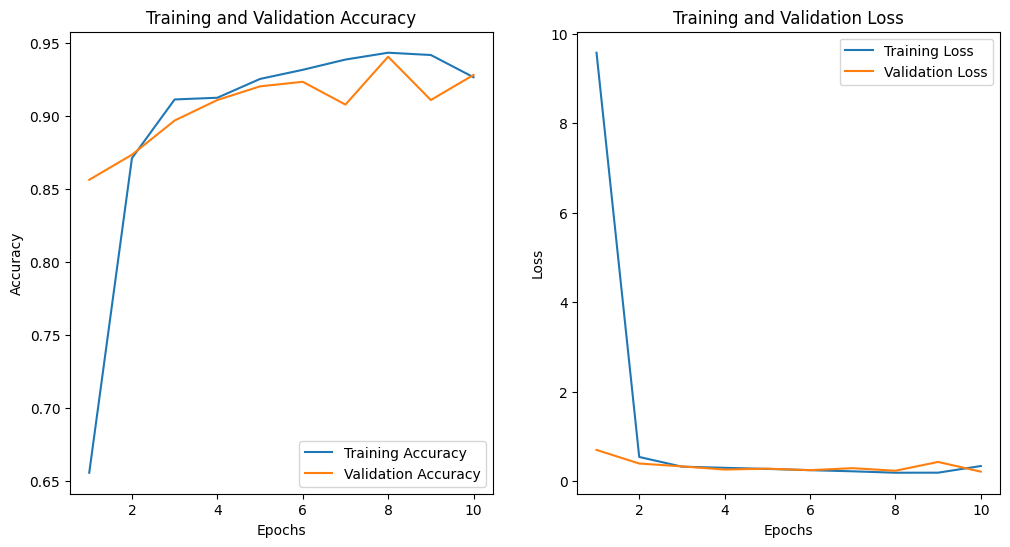

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plot Akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.save(f'D:\\SEMESTER 7\\TA\\modelbaru\\mobilenet.h5')

In [ ]:
accuracy = model.evaluate(test_dataset)[1] * 100
print("Accuracy:", accuracy)

25/25 [==============================] - 7s 265ms/step - loss: 0.1921 - accuracy: 0.9463
Accuracy: 94.62500214576721


## Googlenet (InceptionV3)

In [ ]:
def build_model(hp):
    inception = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
    inception.trainable = False
    class_num = 8

    model = tf.keras.models.Sequential()
    model.add(inception)
    model.add(Flatten())

    for i in range(0, hp.Int('num_layers', 0, 3)):
        units = hp.Int(f'dense_{i}_units', min_value = 32, max_value = 1024, step = 32)
        dropout_rate = hp.Float(f'dropout_{i}_rate', min_value = 0.3, max_value = 0.7, step = 0.1)

        model.add(Dense(units = units, activation = 'relu'))
        model.add(Dropout(rate = dropout_rate))

    model.add(Dense(class_num, activation = 'softmax'))

    optimizer = Adam(learning_rate = hp.Choice('learning_rate', values = [0.1, 0.01, 0.001]))
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(
    build_model,  # Fungsi untuk membangun model
    objective='val_accuracy',  # Metrik yang akan dioptimalkan
    max_epochs=10,  # Jumlah maksimum epoch
    factor=3,  # Faktor reduksi untuk jumlah konfigurasi
    directory='D:\\SEMESTER 7\\TA\\tuning',  # Direktori untuk menyimpan hasil pencarian hiperparameter
    project_name='googlenet'  # Nama proyek pencarian hiperparameter
)

In [ ]:
# Menentukan Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik yang akan dipantau (dalam contoh, kita pantau loss pada data validasi)
    patience=3,  # Jumlah epoch tanpa perbaikan sebelum pelatihan dihentikan
    restore_best_weights=True  # Mengembalikan bobot terbaik jika pelatihan dihentikan
)

In [ ]:
tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_learning_rate = best_hps.get('learning_rate')
optimizer = Adam(learning_rate=best_learning_rate)
tuner.results_summary()

Trial 30 Complete [00h 06m 03s]
val_accuracy: 0.753125011920929

Best val_accuracy So Far: 0.7984374761581421
Total elapsed time: 01h 30m 48s
Results summary
Results in D:\SEMESTER 7\TA\tuning\googlenet
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0017 summary
Hyperparameters:
num_layers: 0
learning_rate: 0.1
dense_0_units: 320
dropout_0_rate: 0.6000000000000001
dense_1_units: 64
dropout_1_rate: 0.6000000000000001
dense_2_units: 64
dropout_2_rate: 0.6000000000000001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
Score: 0.7984374761581421

Trial 0024 summary
Hyperparameters:
num_layers: 0
learning_rate: 0.001
dense_0_units: 672
dropout_0_rate: 0.5
dense_1_units: 512
dropout_1_rate: 0.6000000000000001
dense_2_units: 992
dropout_2_rate: 0.4
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
Score: 0.784375011920929

Trial 0016 summary
Hyperparameters:
num_layers: 0
lear

In [ ]:
model = build_model(best_hps)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)
model.summary()

Epoch 1/10
80/80 [==============================] - 47s 559ms/step - loss: 20458.8633 - accuracy: 0.4664 - val_loss: 5005.6016 - val_accuracy: 0.6328
Epoch 2/10
80/80 [==============================] - 45s 559ms/step - loss: 4211.2783 - accuracy: 0.6863 - val_loss: 4432.8550 - val_accuracy: 0.6812
Epoch 3/10
80/80 [==============================] - 45s 560ms/step - loss: 3171.7168 - accuracy: 0.7449 - val_loss: 4382.3833 - val_accuracy: 0.7000
Epoch 4/10
80/80 [==============================] - 44s 557ms/step - loss: 3103.3225 - accuracy: 0.7711 - val_loss: 5747.8721 - val_accuracy: 0.6938
Epoch 5/10
80/80 [==============================] - 44s 557ms/step - loss: 3295.8374 - accuracy: 0.7855 - val_loss: 4431.7915 - val_accuracy: 0.7031
Epoch 6/10
80/80 [==============================] - 44s 557ms/step - loss: 2054.3718 - accuracy: 0.8355 - val_loss: 4074.9675 - val_accuracy: 0.7391
Epoch 7/10
80/80 [==============================] - 44s 555ms/step - loss: 1696.9359 - accuracy: 0.8512 -

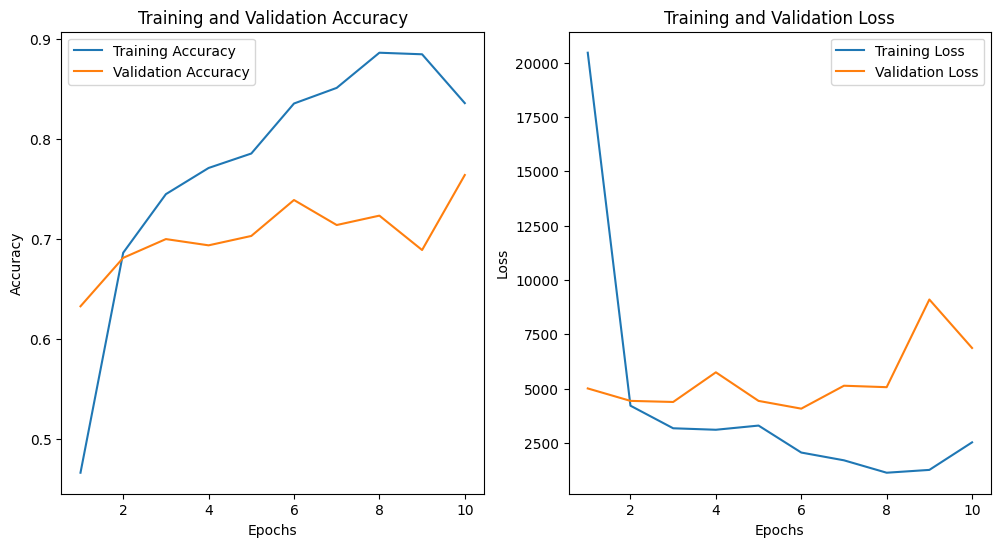

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plot Akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.save(f'D:\\SEMESTER 7\\TA\\modelbaru\\googlenet.h5')

In [ ]:
accuracy = model.evaluate(test_dataset)[1] * 100
print("Accuracy:", accuracy)

25/25 [==============================] - 11s 452ms/step - loss: 7536.2456 - accuracy: 0.7138
Accuracy: 71.37500047683716


## Alexnet

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, monitor='val_loss', mode='min'):
        self.patience = patience
        self.delta = delta
        self.monitor = monitor
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

        if mode == 'min':
            self.best_score = float('inf')
        elif mode == 'max':
            self.best_score = float('-inf')

    def __call__(self, val_loss):
        if self.mode == 'min':
            score = -val_loss
        elif self.mode == 'max':
            score = val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

        return self.early_stop, score

In [ ]:
# Mendefinisikan model AlexNet dengan penambahan layer baru
class CustomAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomAlexNet, self).__init__()
        # Mengambil bagian features dari model AlexNet
        self.features = models.alexnet(pretrained=True).features

        # Menambahkan layer baru ke dalam classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, num_classes)  # Layer output untuk multiclass
        )

        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Tanpa Dense

In [ ]:
# List untuk menyimpan akurasi dan loss
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Fungsi objektif untuk optimasi
def objective(trial):
    # Mendapatkan hyperparameter yang diuji
    learning_rate = trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001])

    # Membuat model CustomAlexNet
    custom_alexnet = CustomAlexNet(
                        num_classes=8).to(device)

    # Menentukan fungsi loss dan optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(custom_alexnet.parameters(), lr=learning_rate)

    # Early Stopping
    early_stopping = EarlyStopping(patience=5, monitor='val_loss', mode='min')

    # Melatih model
    num_epochs = 10  # Ganti dengan nilai epoch yang sesuai
    best_val_accuracy = 0.0
    best_model = None

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        true_labels_train = []
        predicted_labels_train = []

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = custom_alexnet(images)
            loss = criterion(outputs, labels.long())

            # Backward dan optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Hitung metrik pelatihan
            running_loss += loss.item()
            predicted = torch.argmax(outputs.data, dim=1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Kumpulkan label sebenarnya dan label yang diprediksi untuk perhitungan precision, recall, dan f1-score
            true_labels_train.extend(labels.cpu().numpy())
            predicted_labels_train.extend(predicted.cpu().numpy())

        # Akhiri epoch, hitung metrik pelatihan
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Uji model pada dataset validasi
        custom_alexnet.eval()
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            val_loss = 0.0

            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = custom_alexnet(images)
                loss = criterion(outputs, labels.long())

                predicted_val = torch.argmax(outputs.data, dim=1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

                # Hitung metrik validasi
                val_loss += loss.item()

            val_accuracy = correct_val / total_val
            val_loss /= len(val_loader)

            # Early stopping check
            if early_stopping(val_loss):
                print("Early stopping triggered.")
                break

            # Save the best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model = custom_alexnet.state_dict()

        custom_alexnet.train()  # Kembalikan model ke mode pelatihan

    torch.save(best_model, 'D:\TA\hp\alexnet\alexnet.pth')

    # Menyimpan metrik-metrik untuk setiap epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    return val_accuracy

# Mengatur perangkat (device) CUDA jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(dataset=x_train)
test_loader = torch.utils.data.DataLoader(dataset=x_test)
val_loader = torch.utils.data.DataLoader(dataset=x_valid)

# Menggunakan Optuna untuk optimasi hyperparameter
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective, n_trials=30)  # Ganti n_trials dengan jumlah uji yang diinginkan

# Menampilkan hasil optimal
best_trial1 = study1.best_trial
print(f"Best Trial - Accuracy: {best_trial1.value:.4f}")
print("Best Trial - Hyperparameters:")
for key, value in best_trial1.params.items():
    print(f"  {key}: {value}")

[I 2023-12-07 23:48:17,854] A new study created in memory with name: no-name-abaab842-3cce-4374-8520-970b2471f392
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[W 2023-12-07 23:48:18,101] Trial 0 failed with parameters: {'learnin

ValueError: not enough values to unpack (expected 2, got 1)

### 1 Dense

### 3 Dense

### 2 Dense

In [ ]:
# Mendefinisikan model AlexNet dengan penambahan layer baru
class CustomAlexNet(nn.Module):
    def _init_(self, num_classes, units_layer1, units_layer2, dropout_rate1, dropout_rate2):
        super(CustomAlexNet, self)._init_()
        # Mengambil bagian features dari model AlexNet
        self.features = models.alexnet(pretrained=True).features

        # Menambahkan layer baru ke dalam classifier
        self.classifier = nn.Sequential(
            # nn.AdaptiveAvgPool2d((6,6)),
            nn.Flatten(),
            # nn.Linear(256 * 6 * 6, units_layer1),
            # nn.ReLU(inplace=True),
            # nn.Dropout(dropout_rate1),
            # nn.Linear(units_layer1, units_layer2),
            # nn.ReLU(inplace=True),
            # nn.Dropout(dropout_rate2),
            # nn.Linear(units_layer2, num_classes)  # Layer output untuk multiclass
            nn.Linear(256 * 6 * 6, num_classes)  # Layer output untuk multiclass
        )

        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
# List untuk menyimpan akurasi dan loss
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Fungsi objektif untuk optimasi
def objective(trial):
    # Mendapatkan hyperparameter yang diuji
    # units_layer1 = trial.suggest_int('units_layer1', 32, 1024, step=32)
    # units_layer2 = trial.suggest_int('units_layer2', 32, 1024, step=32)
    # dropout_rate1 = trial.suggest_float('dropout_rate1', 0.3, 0.7, step=0.1)
    # dropout_rate2 = trial.suggest_float('dropout_rate2', 0.3, 0.7, step=0.1)
    learning_rate = trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001])

    # Membuat model CustomAlexNet
    custom_alexnet = CustomAlexNet(
                        num_classes=8
                        # units_layer1=units_layer1,
                        # units_layer2=units_layer2,
                        # dropout_rate1=dropout_rate1,
                        # dropout_rate2=dropout_rate2).to(device)
                        ).to(device)

    # Menentukan fungsi loss dan optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(custom_alexnet.parameters(), lr=learning_rate)

    # Early Stopping
    early_stopping = EarlyStopping(patience=5, monitor='val_loss', mode='min')

    # Melatih model
    num_epochs = 10  # Ganti dengan nilai epoch yang sesuai
    best_val_accuracy = 0.0
    best_model = None

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        true_labels_train = []
        predicted_labels_train = []

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = custom_alexnet(images)
            loss = criterion(outputs, labels.long())

            # Backward dan optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Hitung metrik pelatihan
            running_loss += loss.item()
            predicted = torch.argmax(outputs.data, dim=1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Kumpulkan label sebenarnya dan label yang diprediksi untuk perhitungan precision, recall, dan f1-score
            true_labels_train.extend(labels.cpu().numpy())
            predicted_labels_train.extend(predicted.cpu().numpy())

        # Akhiri epoch, hitung metrik pelatihan
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Uji model pada dataset validasi
        custom_alexnet.eval()
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            val_loss = 0.0

            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = custom_alexnet(images)
                loss = criterion(outputs, labels.long())

                predicted_val = torch.argmax(outputs.data, dim=1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

                # Hitung metrik validasi
                val_loss += loss.item()

            val_accuracy = correct_val / total_val
            val_loss /= len(val_loader)

            # Early stopping check
            if early_stopping(val_loss):
                print("Early stopping triggered.")
                break

            # Save the best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model = custom_alexnet.state_dict()

        custom_alexnet.train()  # Kembalikan model ke mode pelatihan

    torch.save(best_model, 'D:\TA\hp\alexnet\alexnet.pth')

    # Hitung precision, recall, dan f1-score untuk setiap epoch
    precision_train = precision_score(true_labels_train, predicted_labels_train, average='weighted')
    recall_train = recall_score(true_labels_train, predicted_labels_train, average='weighted')
    f1_train = f1_score(true_labels_train, predicted_labels_train, average='weighted')

    # Menyimpan metrik-metrik untuk setiap epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    return val_accuracy

# Mengatur perangkat (device) CUDA jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    RandomShear(degrees=0, shear_range=(0, 0.2)),  # Adjust shear_range as needed
    transforms.RandomRotation(180),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root='E:/Kuliah/Semester 7/TA/Dataset/Remove BG/Jenis Ikan/train', transform=transform)
test_dataset = datasets.ImageFolder(root='E:/Kuliah/Semester 7/TA/Dataset/Remove BG/Jenis Ikan/test', transform=transform_test_val)
val_dataset = datasets.ImageFolder(root='E:/Kuliah/Semester 7/TA/Dataset/Remove BG/Jenis Ikan/val', transform=transform_test_val)

# Menghitung bobot untuk setiap sampel
# targets = torch.tensor(train_dataset.targets)
# class_sample_count = torch.unique(targets, return_counts=True)[1]
# weights = 1 / class_sample_count.float()

# Membuat WeightedRandomSampler
# sampler = WeightedRandomSampler(weights, len(weights))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# Menggunakan Optuna untuk optimasi hyperparameter
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective, n_trials=100)  # Ganti n_trials dengan jumlah uji yang diinginkan

# Menampilkan hasil optimal
best_trial1 = study1.best_trial
print(f"Best Trial - Accuracy: {best_trial1.value:.4f}")
print("Best Trial - Hyperparameters:")
for key, value in best_trial1.params.items():
    print(f"  {key}: {value}")

In [ ]:
def build_model(hp):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 2
    model.add(Conv2D(256, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 3
    model.add(Conv2D(384, (3, 3), activation='relu'))

    # Layer 4
    model.add(Conv2D(384, (3, 3), activation='relu'))

    # Layer 5
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Hyperparameter untuk jumlah unit pada layer Dense
    hp_units = hp.Int('units', min_value=32, max_value=1024, step=32)

    # Hyperparameter untuk dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)

    # Dense layers with dropout
    # model.add(Dense(units=hp_units, activation='relu'))
    # model.add(Dropout(rate=hp_dropout))
    # model.add(Dense(units=hp_units, activation='relu'))
    # model.add(Dropout(rate=hp_dropout))
    # model.add(Dense(units=hp_units, activation='relu'))
    # model.add(Dropout(rate=hp_dropout))

    # Output layer
    model.add(Dense(8, activation='softmax'))

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001]))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def build_model(hp):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 2
    model.add(Conv2D(256, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 3
    model.add(Conv2D(384, (3, 3), activation='relu'))

    # Layer 4
    model.add(Conv2D(384, (3, 3), activation='relu'))

    # Layer 5
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Hyperparameter untuk jumlah unit pada layer Dense
    hp_units = hp.Int('units', min_value=32, max_value=1024, step=32)

    # Hyperparameter untuk dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)

    # Dense layers with dropout
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dropout(rate=hp_dropout))
    # model.add(Dense(units=hp_units, activation='relu'))
    # model.add(Dropout(rate=hp_dropout))
    # model.add(Dense(units=hp_units, activation='relu'))
    # model.add(Dropout(rate=hp_dropout))

    # Output layer
    model.add(Dense(8, activation='softmax'))

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001]))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def build_model(hp):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 2
    model.add(Conv2D(256, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 3
    model.add(Conv2D(384, (3, 3), activation='relu'))

    # Layer 4
    model.add(Conv2D(384, (3, 3), activation='relu'))

    # Layer 5
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Hyperparameter untuk jumlah unit pada layer Dense
    hp_units = hp.Int('units', min_value=32, max_value=1024, step=32)

    # Hyperparameter untuk dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)

    # Dense layers with dropout
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dropout(rate=hp_dropout))
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dropout(rate=hp_dropout))
    # model.add(Dense(units=hp_units, activation='relu'))
    # model.add(Dropout(rate=hp_dropout))

    # Output layer
    model.add(Dense(8, activation='softmax'))

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001]))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def build_model(hp):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 2
    model.add(Conv2D(256, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 3
    model.add(Conv2D(384, (3, 3), activation='relu'))

    # Layer 4
    model.add(Conv2D(384, (3, 3), activation='relu'))

    # Layer 5
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Hyperparameter untuk jumlah unit pada layer Dense
    hp_units = hp.Int('units', min_value=32, max_value=1024, step=32)

    # Hyperparameter untuk dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)

    # Dense layers with dropout
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dropout(rate=hp_dropout))
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dropout(rate=hp_dropout))
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dropout(rate=hp_dropout))

    # Output layer
    model.add(Dense(8, activation='softmax'))

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001]))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
tuner = kt.Hyperband(
    build_model,  # Fungsi untuk membangun model
    objective='val_accuracy',  # Metrik yang akan dioptimalkan
    max_epochs=10,  # Jumlah maksimum epoch
    factor=3,  # Faktor reduksi untuk jumlah konfigurasi
    directory='../hp/Polosan',  # Direktori untuk menyimpan hasil pencarian hiperparameter
    project_name='alexnet'  # Nama proyek pencarian hiperparameter
)

In [ ]:
tuner = kt.Hyperband(
    build_model,  # Fungsi untuk membangun model
    objective='val_accuracy',  # Metrik yang akan dioptimalkan
    max_epochs=10,  # Jumlah maksimum epoch
    factor=3,  # Faktor reduksi untuk jumlah konfigurasi
    directory='../hp/3',  # Direktori untuk menyimpan hasil pencarian hiperparameter
    project_name='alexnet1dense'  # Nama proyek pencarian hiperparameter
)

In [ ]:
tuner = kt.Hyperband(
    build_model,  # Fungsi untuk membangun model
    objective='val_accuracy',  # Metrik yang akan dioptimalkan
    max_epochs=10,  # Jumlah maksimum epoch
    factor=3,  # Faktor reduksi untuk jumlah konfigurasi
    directory='../hp/3',  # Direktori untuk menyimpan hasil pencarian hiperparameter
    project_name='alexnet2dense'  # Nama proyek pencarian hiperparameter
)

In [ ]:
tuner = kt.Hyperband(
    build_model,  # Fungsi untuk membangun model
    objective='val_accuracy',  # Metrik yang akan dioptimalkan
    max_epochs=10,  # Jumlah maksimum epoch
    factor=3,  # Faktor reduksi untuk jumlah konfigurasi
    directory='../hp/3',  # Direktori untuk menyimpan hasil pencarian hiperparameter
    project_name='alexnet3dense'  # Nama proyek pencarian hiperparameter
)

In [ ]:
# polosan
tuner.search(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10, callbacks=[early_stopping])

# Dapatkan learning rate terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_learning_rate = best_hps.get('learning_rate')

# Gunakan learning rate terbaik dalam optimizer
optimizer = Adam(learning_rate=best_learning_rate)

Trial 30 Complete [00h 04m 38s]
val_accuracy: 0.14374999701976776

Best val_accuracy So Far: 0.800000011920929
Total elapsed time: 01h 00m 00s


In [ ]:
# 1 dense
tuner.search(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10, callbacks=[early_stopping])

# Dapatkan learning rate terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_learning_rate = best_hps.get('learning_rate')

# Gunakan learning rate terbaik dalam optimizer
optimizer = Adam(learning_rate=best_learning_rate)

Trial 30 Complete [00h 05m 08s]
val_accuracy: 0.14374999701976776

Best val_accuracy So Far: 0.8062499761581421
Total elapsed time: 00h 58m 54s


In [ ]:
# 2 dense
tuner.search(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10, callbacks=[early_stopping])

# Dapatkan learning rate terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_learning_rate = best_hps.get('learning_rate')

# Gunakan learning rate terbaik dalam optimizer
optimizer = Adam(learning_rate=best_learning_rate)

Trial 30 Complete [00h 03m 37s]
val_accuracy: 0.14374999701976776

Best val_accuracy So Far: 0.6640625
Total elapsed time: 00h 59m 28s


In [ ]:
# 3 dense
tuner.search(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10, callbacks=[early_stopping])

# Dapatkan learning rate terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_learning_rate = best_hps.get('learning_rate')

# Gunakan learning rate terbaik dalam optimizer
optimizer = Adam(learning_rate=best_learning_rate)

Trial 30 Complete [00h 03m 24s]
val_accuracy: 0.11562500149011612

Best val_accuracy So Far: 0.13593749701976776
Total elapsed time: 00h 57m 24s


In [ ]:
# Polosan
model = build_model(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 384)        

In [ ]:
# 1 dense
model = build_model(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 384)        

In [ ]:
# 2 dense
model = build_model(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 384)        

In [ ]:
# 3 dense
model = build_model(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 384)        

In [ ]:
# Polosan
accuracy = model.evaluate(x_test, y_test)[1] * 100
print("Accuracy:", accuracy)

25/25 [==============================] - 2s 85ms/step - loss: 26.3600 - accuracy: 0.1112
Accuracy: 11.124999821186066


In [ ]:
# 1 dense
accuracy = model.evaluate(x_test, y_test)[1] * 100
print("Accuracy:", accuracy)

25/25 [==============================] - 2s 92ms/step - loss: 11.3840 - accuracy: 0.1350
Accuracy: 13.500000536441803


In [ ]:
# 2 dense
accuracy = model.evaluate(x_test, y_test)[1] * 100
print("Accuracy:", accuracy)

25/25 [==============================] - 2s 91ms/step - loss: 3.8404 - accuracy: 0.1112
Accuracy: 11.124999821186066


In [ ]:
# 3 dense
accuracy = model.evaluate(x_test, y_test)[1] * 100
print("Accuracy:", accuracy)

25/25 [==============================] - 2s 92ms/step - loss: 7.9423 - accuracy: 0.1363
Accuracy: 13.625000417232513


## Testing

In [ ]:
model = load_model('D:\\SEMESTER 7\\TA\\modelb\\resnet50.h5')
images = []
img = cv2.imread("D:\\SEMESTER 7\\TA\\20211231_123105 (Custom).jpg")
vals = ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']
threshold = 0.7
img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

images.append(img)
images = np.array(images)

pred = model.predict(images)
top_pred = np.argmax(pred)
label = vals[top_pred]

top_prob = pred[0][top_pred]  # Mendapatkan probabilitas prediksi tertinggi

if top_prob >= threshold:
    print("Indeks prediksi tertinggi:", top_pred)
    print("Label prediksi:", label)
    print("Probabilitas prediksi tertinggi:", top_prob)
else:
    print("Gambar tidak dikenali")

print(label)
print(pred)


1/1 [==============================] - 1s 707ms/step
Indeks prediksi tertinggi: 5
Label prediksi: Healthy
Probabilitas prediksi tertinggi: 1.0
Healthy
[[0. 0. 0. 0. 0. 1. 0. 0.]]


In [ ]:
# Gantilah path model dengan path yang sesuai
model_path = 'D:\\SEMESTER 7\\TA\\model\\resnet50.h5'

# Load model
model = tf.keras.models.load_model(model_path)

# Misalkan model Anda telah dilatih dan disimpan dalam variabel 'model'
# Misalkan 'val_dataset' atau 'test_dataset' berisi tuple (X, y), di mana X adalah gambar dan y adalah label

# Melakukan prediksi pada dataset validasi atau test
predictions = model.predict(test_dataset)

# Mengonversi hasil probabilitas prediksi menjadi label kelas
predicted_labels = np.argmax(predictions, axis=1)

# Mendapatkan label aktual dari dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Menerapkan classification_report
report = classification_report(true_labels, predicted_labels)

# Menampilkan classification_report
print(report)


25/25 [==============================] - 21s 831ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       100
           1       1.00      0.98      0.99       100
           2       1.00      1.00      1.00       100
           3       0.99      0.98      0.98       100
           4       0.99      0.95      0.97       100
           5       1.00      1.00      1.00       100
           6       0.98      0.99      0.99       100
           7       0.99      0.98      0.98       100

    accuracy                           0.98       800
   macro avg       0.99      0.98      0.99       800
weighted avg       0.99      0.98      0.99       800



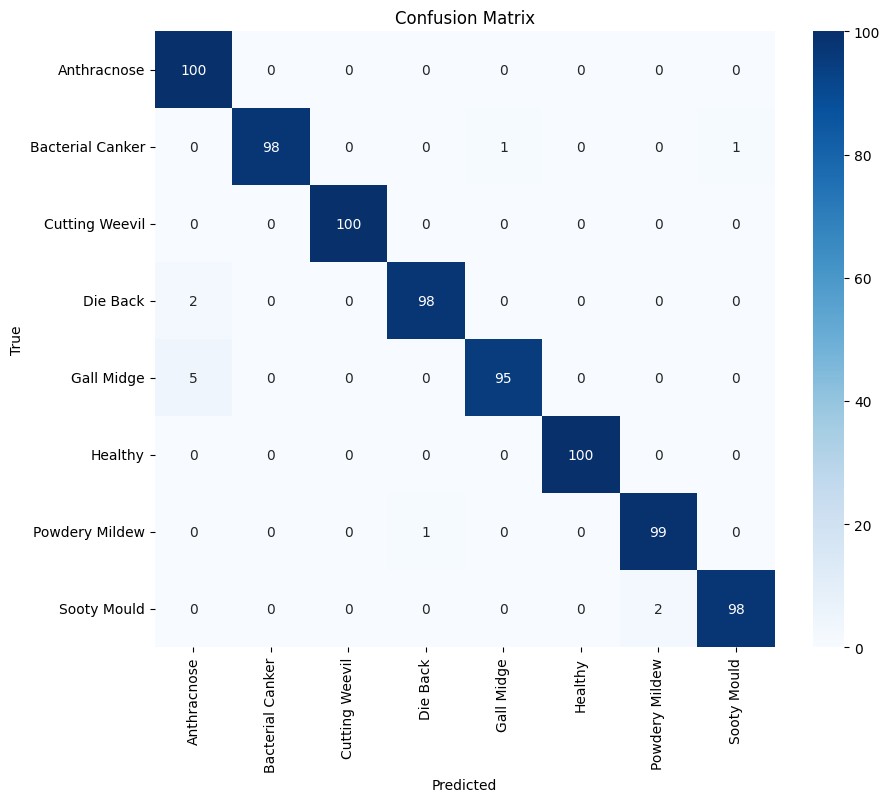

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Menghitung confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Menampilkan confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=vals, yticklabels=vals)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Gantilah path model dengan path yang sesuai
model_path = 'D:\\SEMESTER 7\\TA\\model\\resnet50.h5'

# Load model
model = tf.keras.models.load_model(model_path)

# Misalkan model Anda telah dilatih dan disimpan dalam variabel 'model'
# Misalkan 'val_dataset' atau 'test_dataset' berisi tuple (X, y), di mana X adalah gambar dan y adalah label

# Melakukan prediksi pada dataset validasi atau test
predictions = model.predict(val_dataset)

# Mengonversi hasil probabilitas prediksi menjadi label kelas
predicted_labels = np.argmax(predictions, axis=1)

# Mendapatkan label aktual dari dataset
true_labels = np.concatenate([y for x, y in val_dataset], axis=0)

# Menerapkan classification_report
report = classification_report(true_labels, predicted_labels)

# Menampilkan classification_report
print(report)


20/20 [==============================] - 17s 836ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        80
           1       1.00      0.96      0.98        80
           2       1.00      1.00      1.00        80
           3       0.99      0.99      0.99        80
           4       0.95      0.91      0.93        80
           5       0.94      1.00      0.97        80
           6       0.98      1.00      0.99        80
           7       1.00      0.94      0.97        80

    accuracy                           0.97       640
   macro avg       0.98      0.98      0.97       640
weighted avg       0.98      0.97      0.97       640



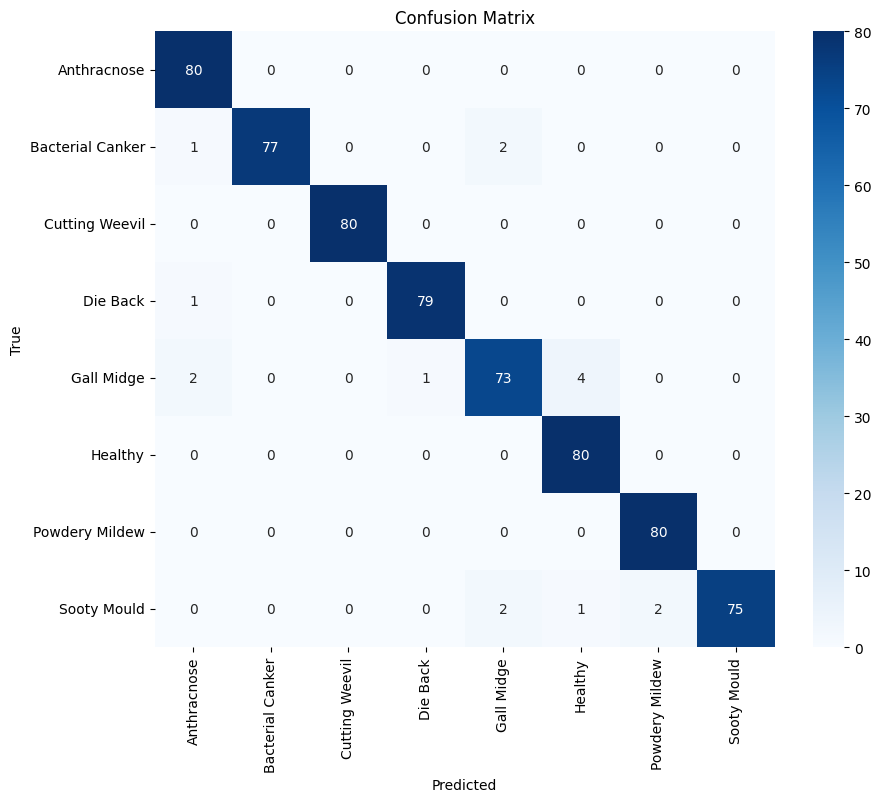

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Menghitung confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Menampilkan confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=vals, yticklabels=vals)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


1/1 [==============================] - 1s 1s/step


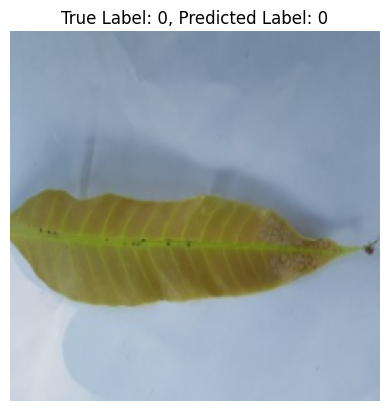

1/1 [==============================] - 1s 889ms/step


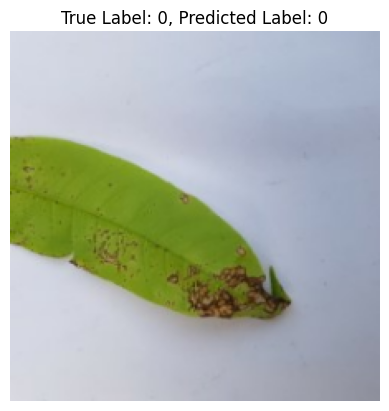

1/1 [==============================] - 1s 862ms/step


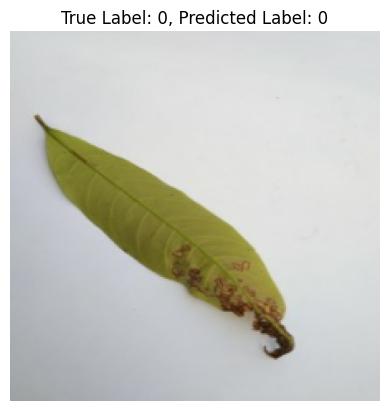

1/1 [==============================] - 1s 857ms/step


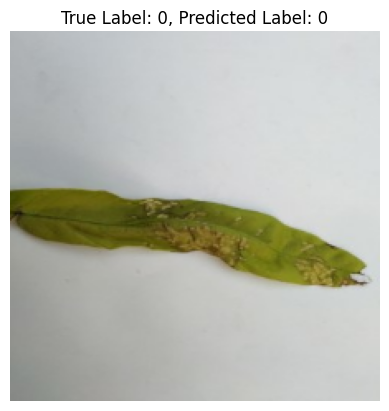

1/1 [==============================] - 1s 858ms/step


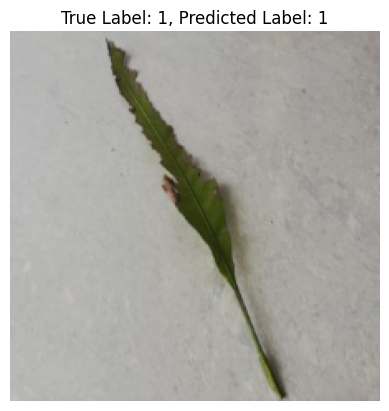

1/1 [==============================] - 1s 853ms/step


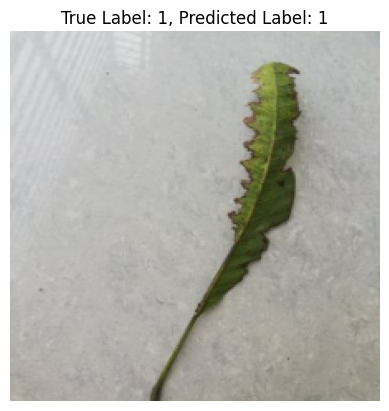

1/1 [==============================] - 1s 861ms/step


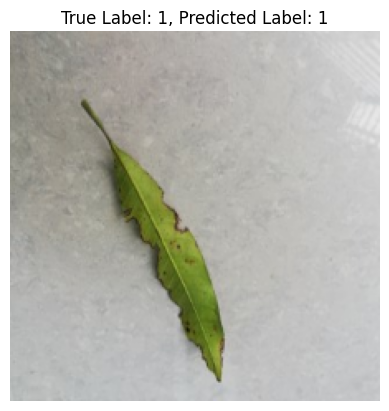

1/1 [==============================] - 1s 855ms/step


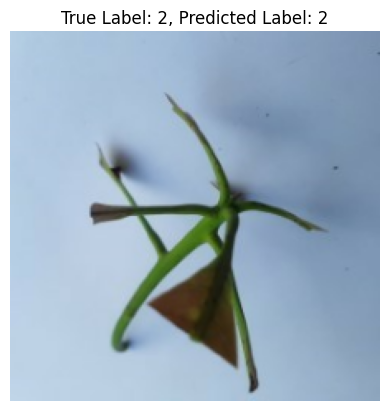

1/1 [==============================] - 1s 850ms/step


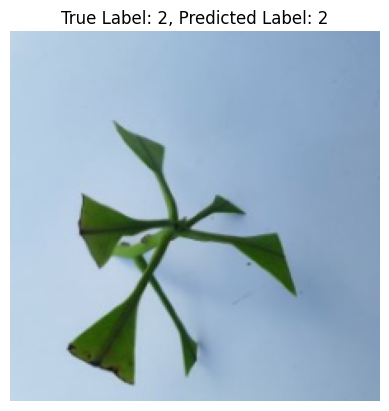

1/1 [==============================] - 1s 848ms/step


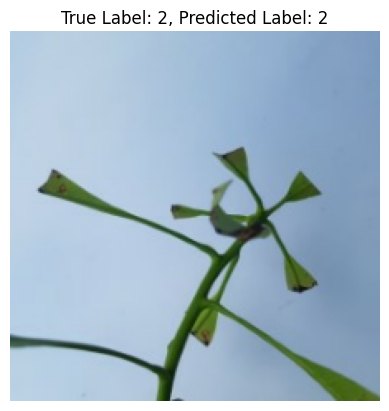

1/1 [==============================] - 1s 848ms/step


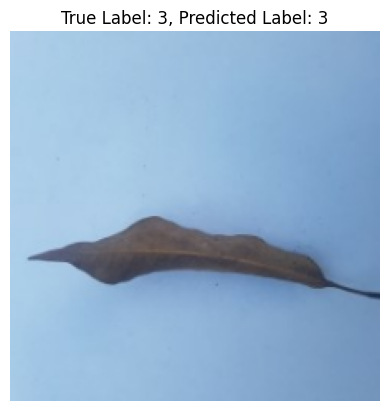

1/1 [==============================] - 1s 869ms/step


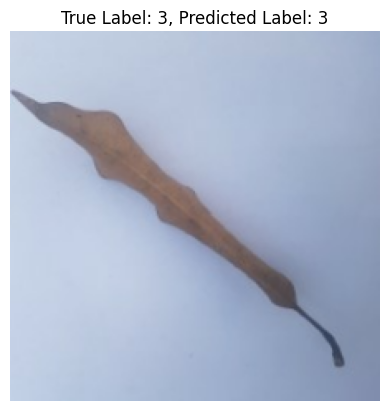

1/1 [==============================] - 1s 857ms/step


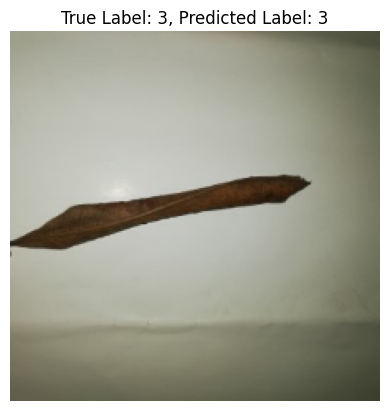

1/1 [==============================] - 1s 845ms/step


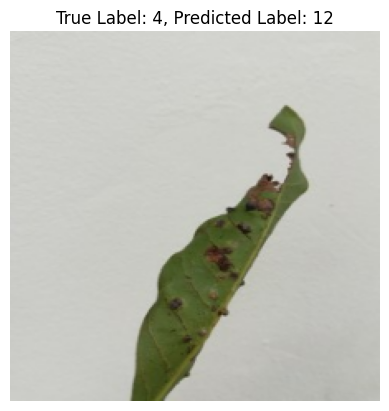

1/1 [==============================] - 1s 835ms/step


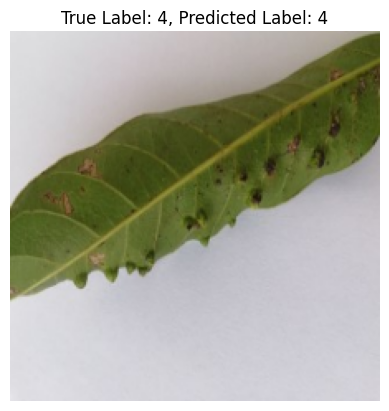

1/1 [==============================] - 1s 837ms/step


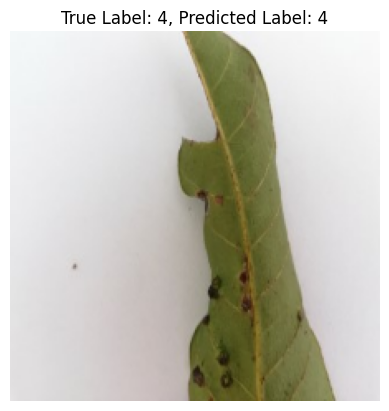

1/1 [==============================] - 1s 853ms/step


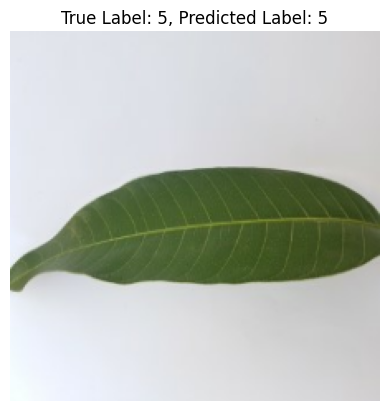

1/1 [==============================] - 1s 844ms/step


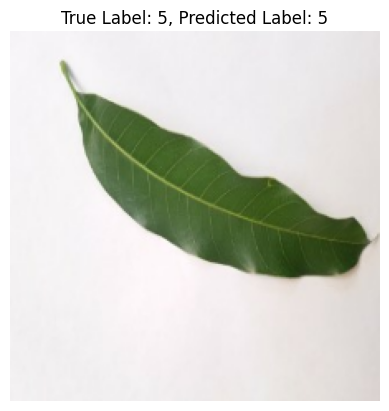

1/1 [==============================] - 1s 867ms/step


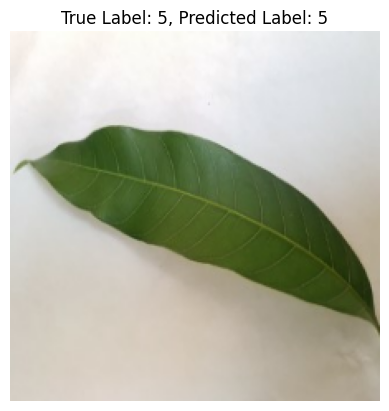

1/1 [==============================] - 1s 868ms/step


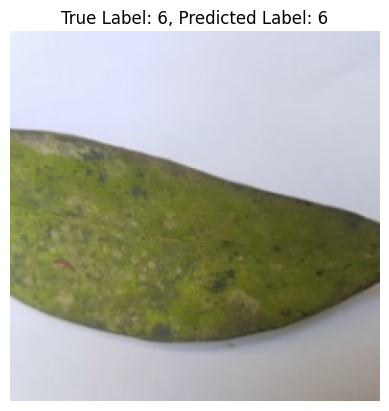

1/1 [==============================] - 1s 885ms/step


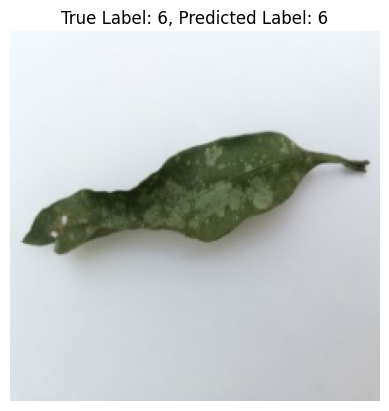

1/1 [==============================] - 1s 866ms/step


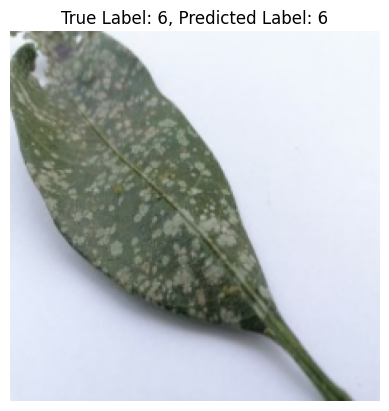

1/1 [==============================] - 1s 867ms/step


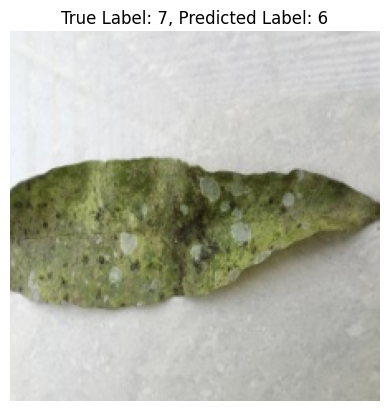

1/1 [==============================] - 1s 880ms/step


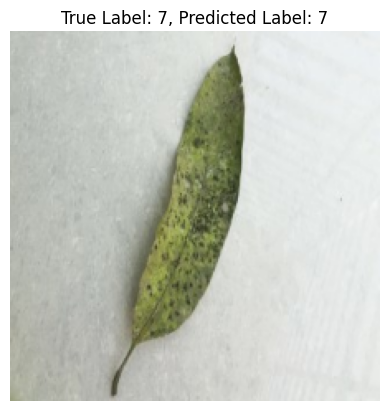

Rata-rata Akurasi: 0.9166666666666666


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow as tf

# Gantilah path model dengan path yang sesuai
model_path = 'D:\\SEMESTER 7\\TA\\model\\resnet50.h5'

# Load model
model = tf.keras.models.load_model(model_path)

# Misalkan 'test_dataset' adalah dataset uji dan 'model' adalah model yang sudah dilatih

# Inisialisasi iterator untuk dataset uji
test_iterator = iter(test_dataset)

# Inisialisasi variabel untuk menyimpan prediksi dan label sebenarnya
true_labels = []
predicted_labels = []

# Jumlah gambar yang ingin ditampilkan
num_images_to_display = 24

# Prediksi label dan menampilkan hasilnya
for i in range(num_images_to_display):
    # Mendapatkan gambar dan label sebenarnya dari dataset uji
    image, true_label = next(test_iterator)

    # Membuat prediksi dengan model
    predicted_probabilities = model.predict(image)
    predicted_label = np.argmax(predicted_probabilities)

    # Menyimpan label sebenarnya dan prediksi
    true_labels.append(true_label[0].numpy())
    predicted_labels.append(predicted_label)

    # Menampilkan gambar
    plt.imshow(image[0].numpy().astype("uint8"))  # gunakan image[0] karena image adalah tensor TensorFlow
    plt.title(f"True Label: {true_label[0]}, Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()

# Menghitung akurasi menggunakan scikit-learn
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Rata-rata Akurasi: {accuracy}")


In [ ]:
import cv2
import numpy as np

# Membaca citra dari file
img = cv2.imread("D:\\SEMESTER 7\\TA\\IMG_20230701_210708.jpg")

# Menetapkan label-label kelas
vals = ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']

# Menetapkan threshold probabilitas
threshold = 0.5

# Mengubah ukuran citra
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)

# Menambahkan dimensi batch (1 citra)
img = np.expand_dims(img, axis=0)

# Melakukan prediksi menggunakan model
pred = model.predict(img)

# Mendapatkan indeks dengan probabilitas prediksi tertinggi
top_pred = np.argmax(pred)

# Mendapatkan label yang sesuai dengan indeks probabilitas tertinggi
label = vals[top_pred]

# Mendapatkan nilai probabilitas tertinggi dari prediksi
top_prob = pred[0][top_pred]

# Mengevaluasi apakah nilai probabilitas tertinggi melebihi threshold yang telah ditetapkan
if top_prob >= threshold:
    print("Label prediksi:", label)
else:
    print("Citra tidak dikenali")

1/1 [==============================] - 0s 89ms/step
Label prediksi: Healthy
